# Virtual Rat
This notebook loads trained weights from pre-determined epoch of training and tests the RNN's performance.
Then the tested results are further analyzed to plot figures.

In [1]:
import numpy as npp
import minpy.numpy as np
import matplotlib.pyplot as plt
import minpy
import scipy.io as sio
minpy.set_global_policy('only_numpy')

from model.VirtualRatModel import VirtualRatModel
from model.VirtualRatSolver import VirtualRatSolver
from model.VirtualRatBox import VirtualRatBox
from model.VirtualRat import VirtualRat
from model.VirtualRatFunctions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading external modules
%load_ext autoreload
%autoreload 2

W0827 07:21:17 14632 minpy.dispatch.registry:register:47] Type MXNet for name reshape has already existed
/gpfsnyu/packages/lpython/2.7/intelpython2/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/gpfsnyu/packages/lpython/2.7/intelpython2/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/gpfsnyu/packages/lpython/2.7/intelpython2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/gpfsnyu/packages/lpython/2.7/intelpython2/lib/python2.7/site-packages/IPython/core/formatters.py:672: DeprecationWarning: PlainTextFormatter

## There is no need to run below cells if you don't want to generate results from scratch!

1


/gpfsnyu/packages/lpython/2.7/intelpython2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/gpfsnyu/packages/lpython/2.7/intelpython2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


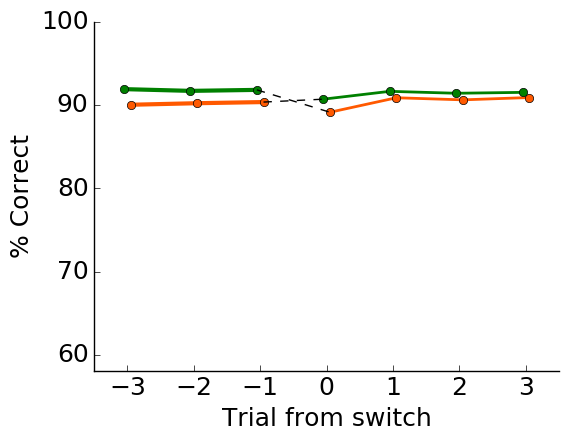

2


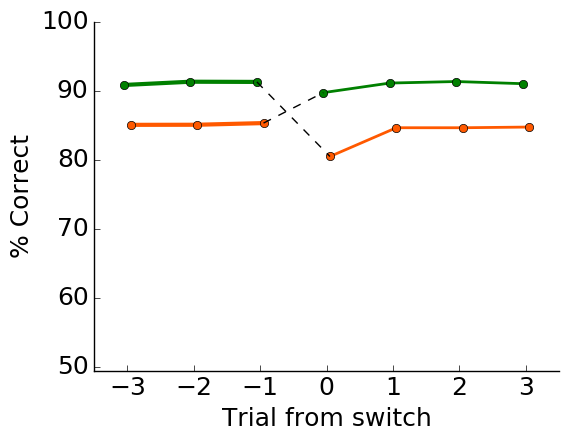

3


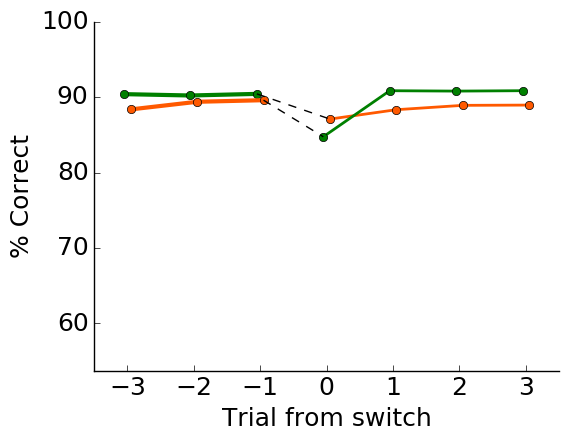

4


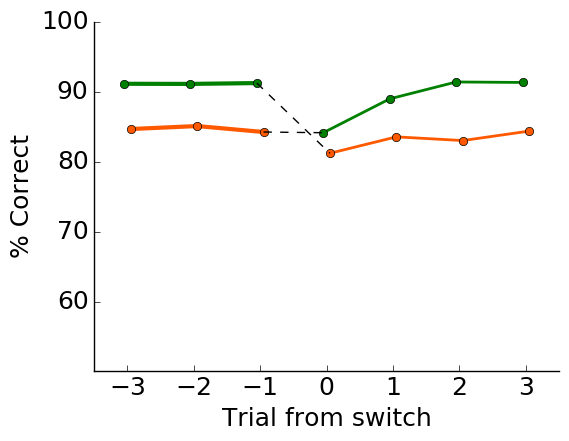

5


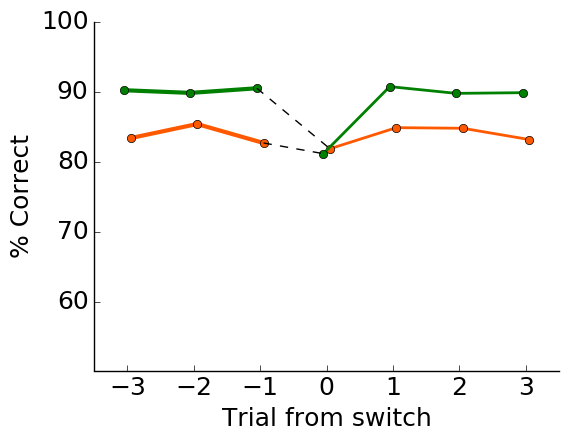

6


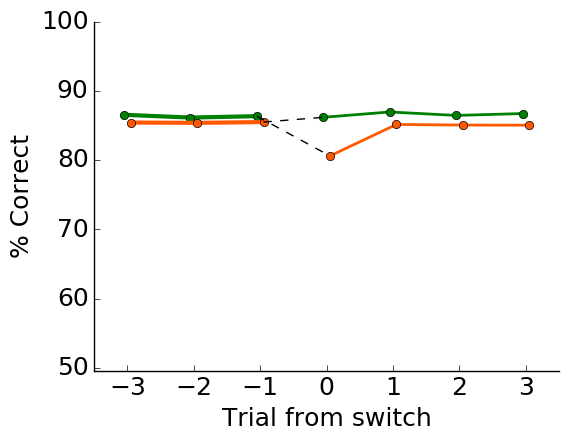

8


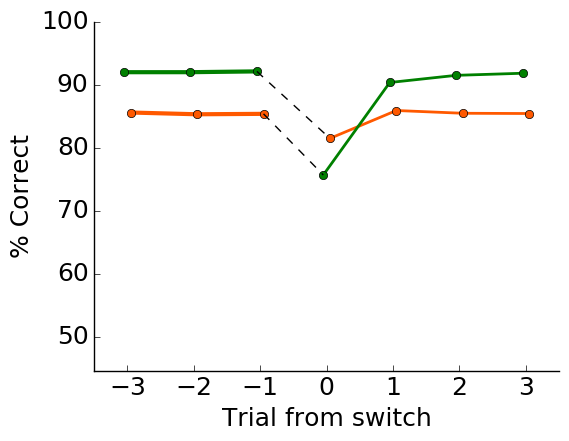

9


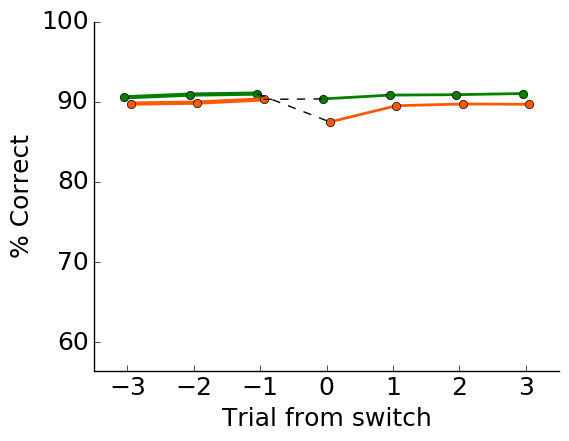

10


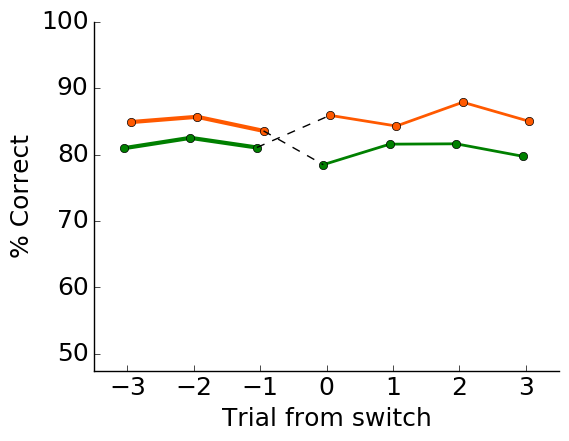

11


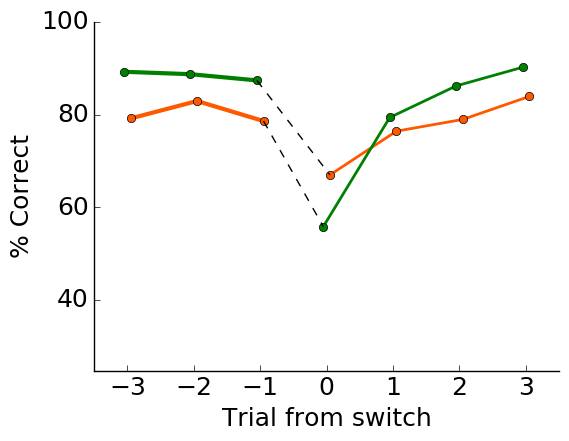

13


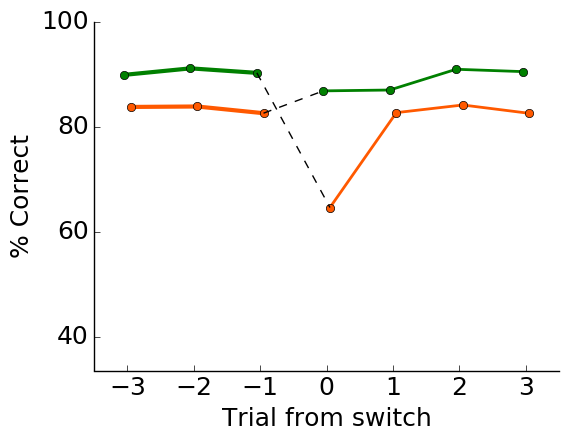

14


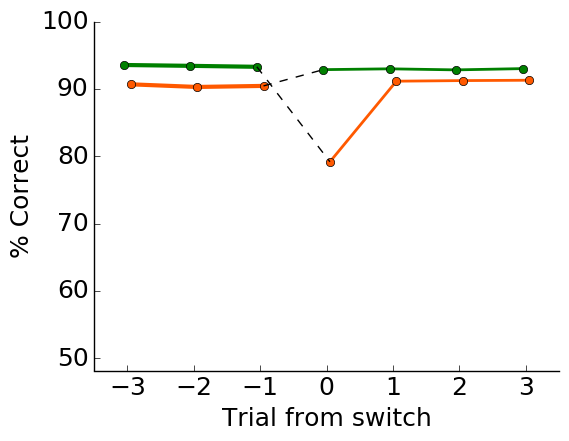

15


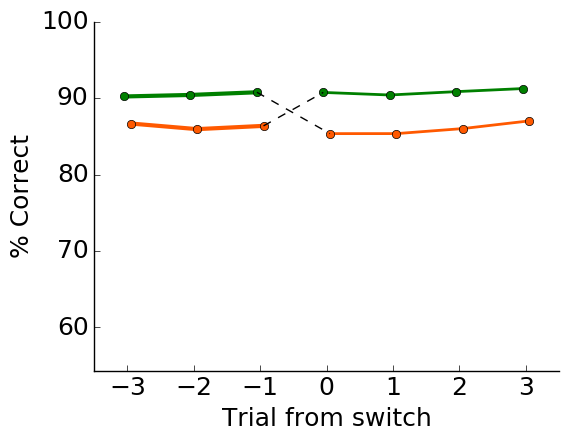

16


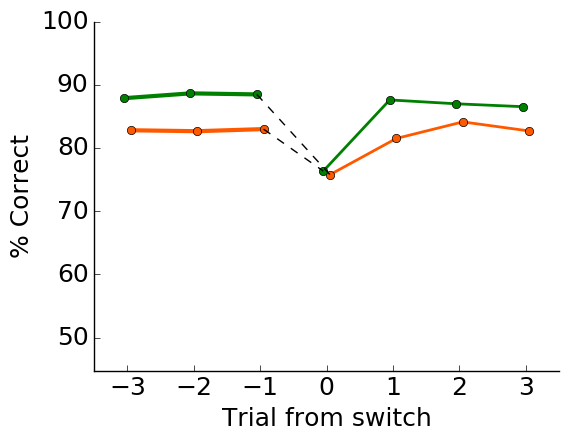

17


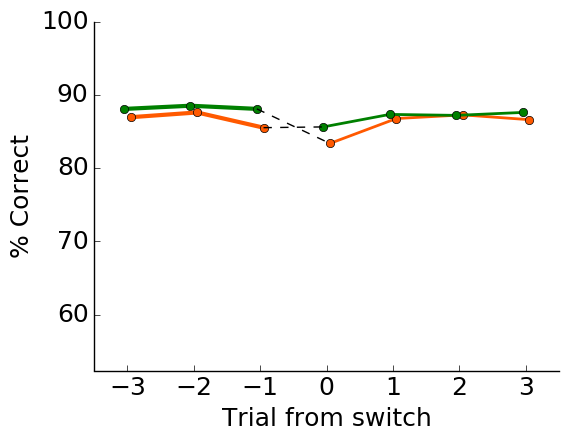

18


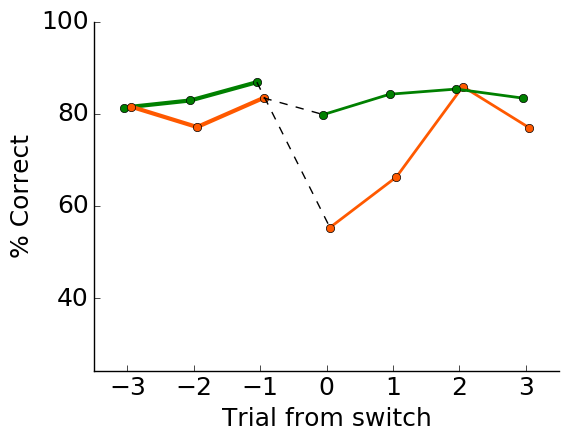

19


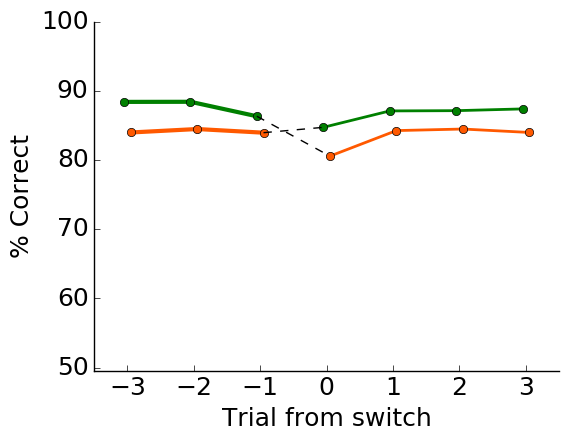

20


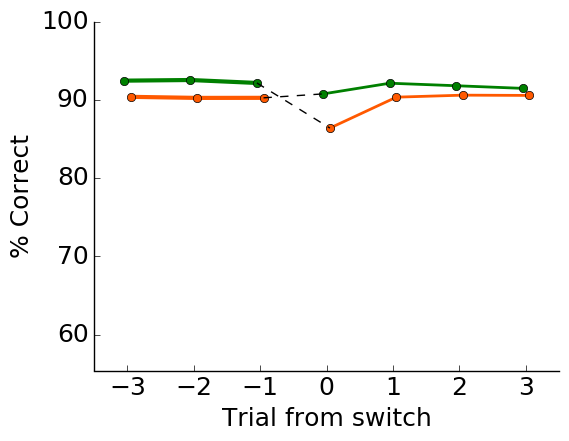

21


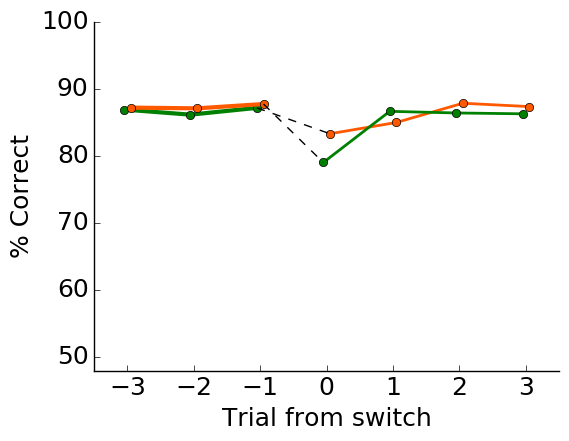

22


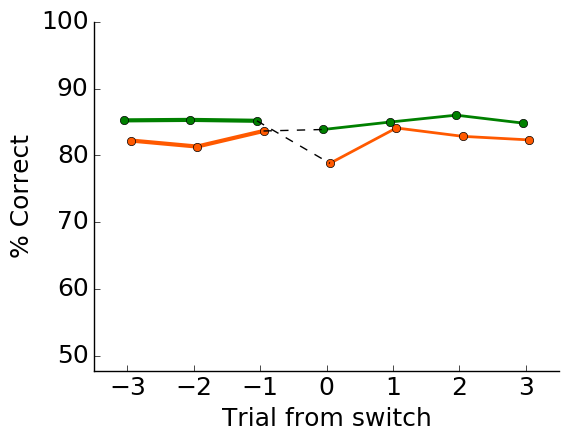

23


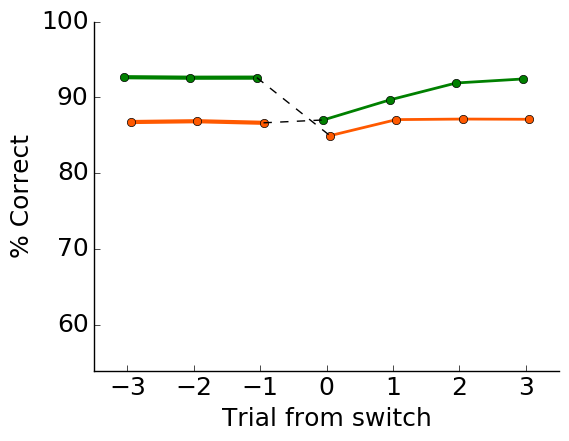

24


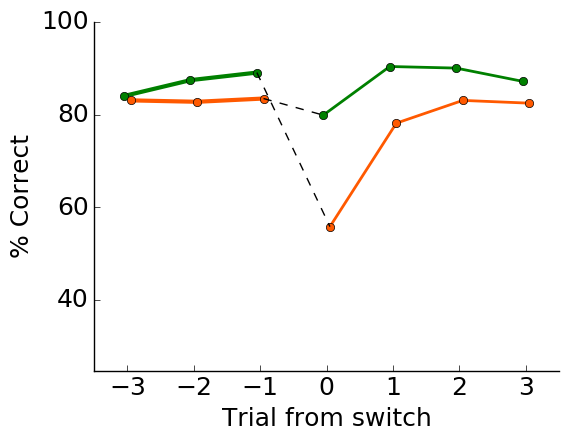

25


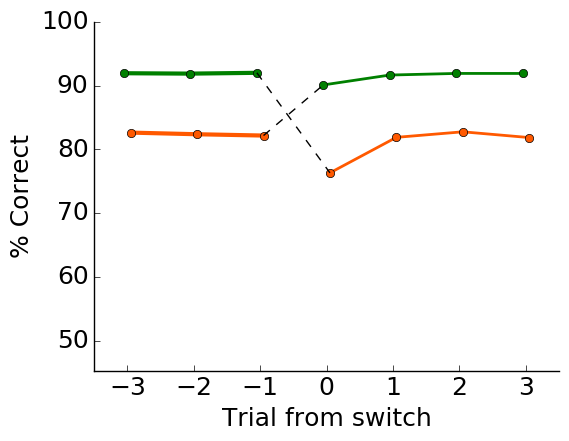

26


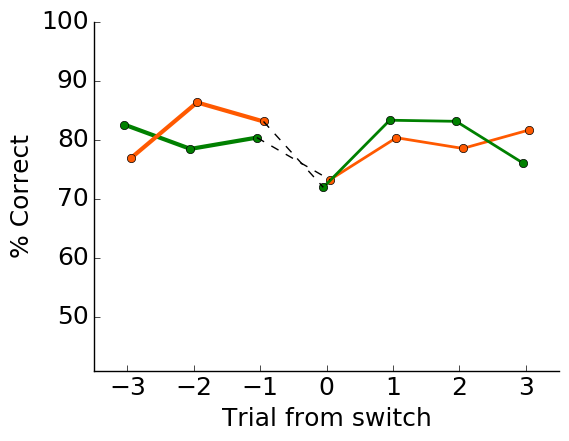

27


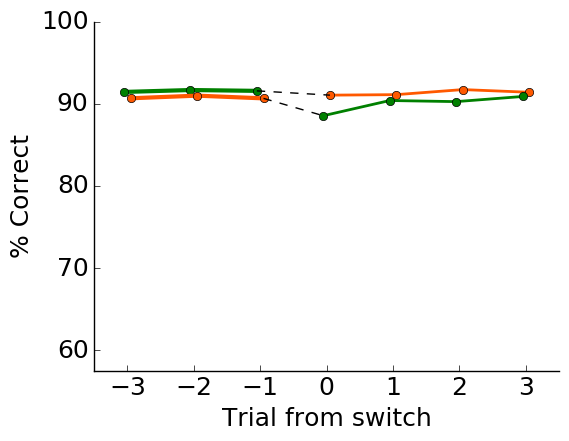

28


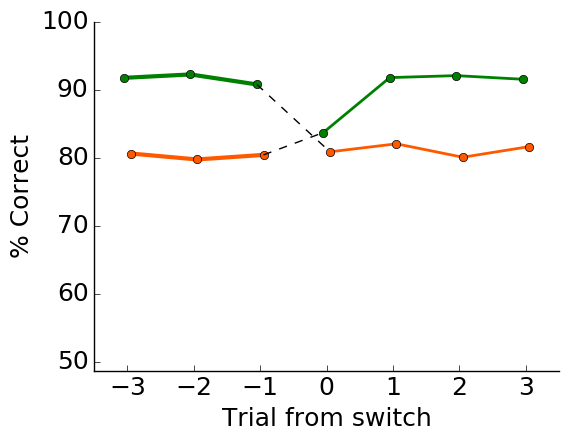

29


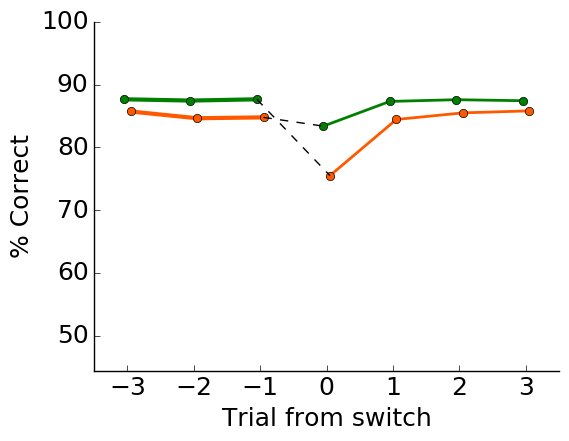

30


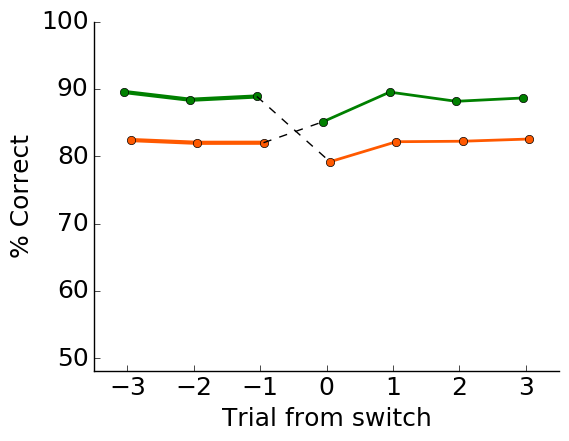

31


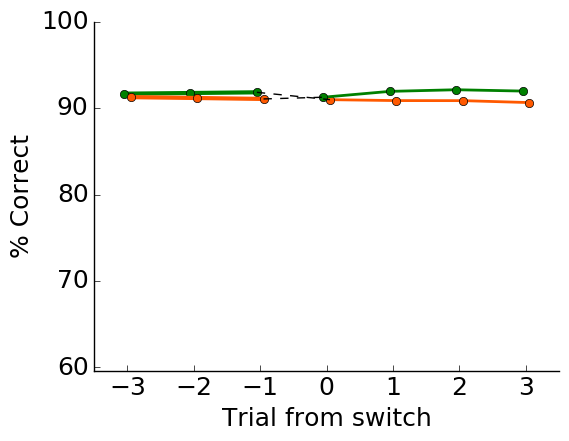

32


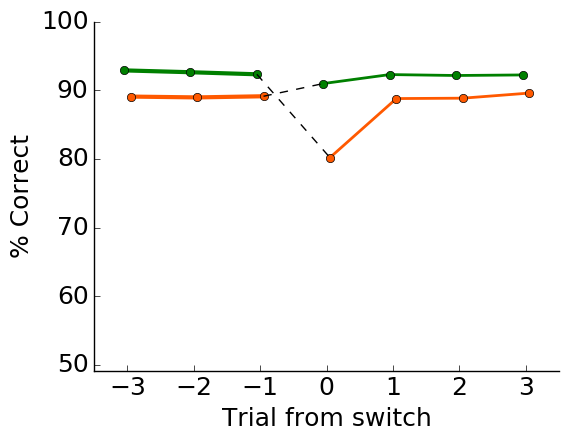

33


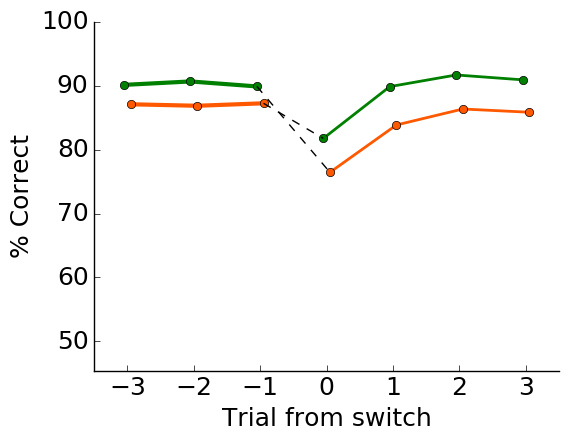

34


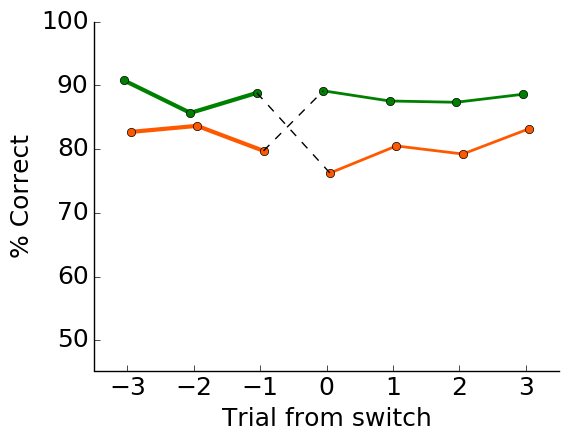

35


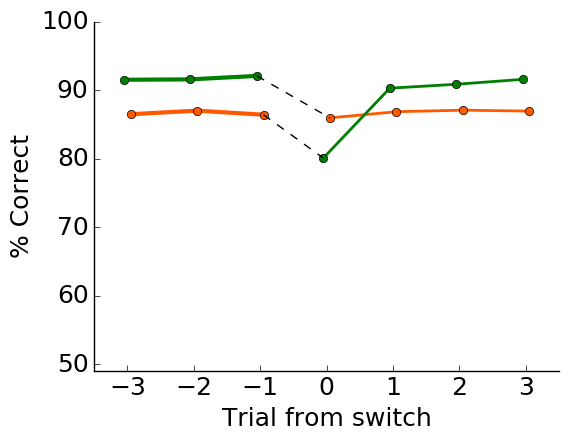

36


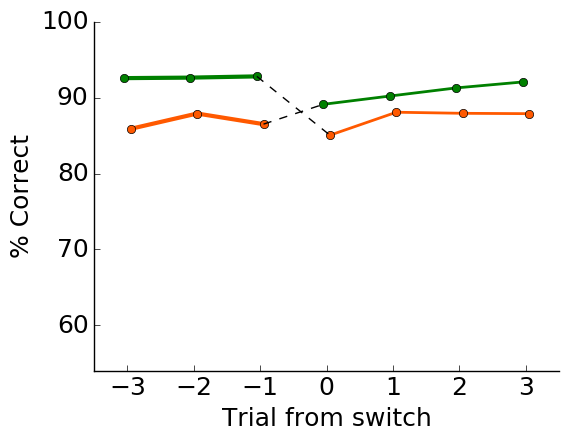

37


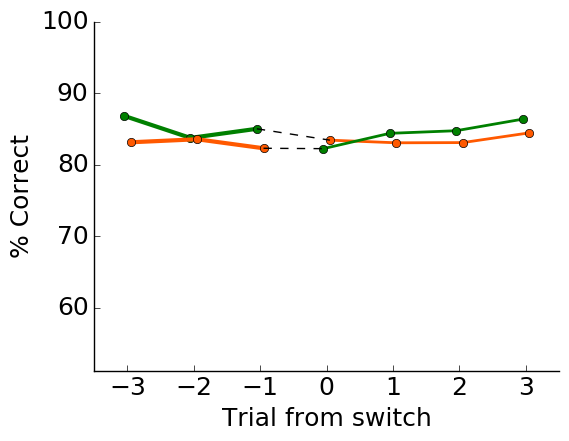

38


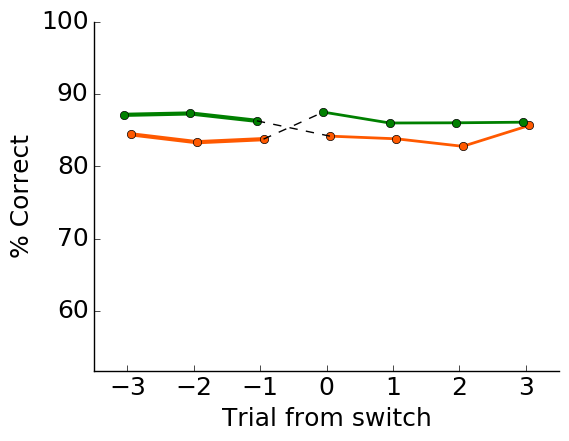

39


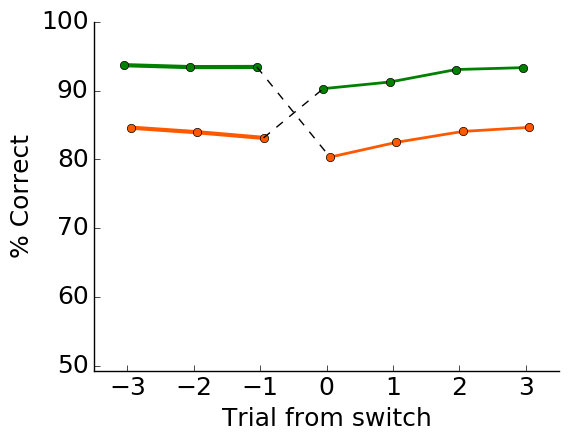

40


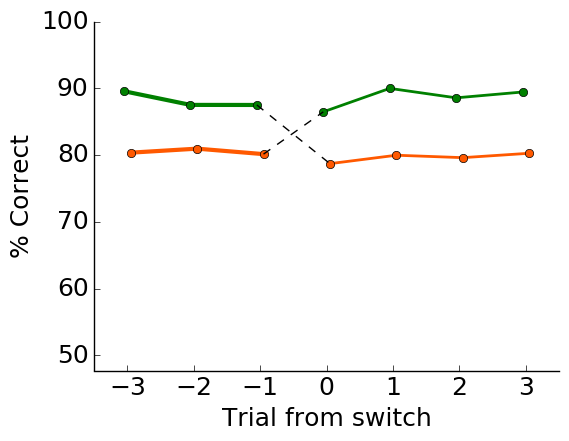

41


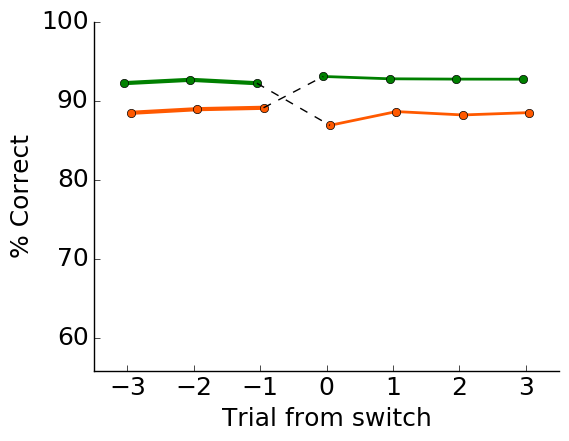

42


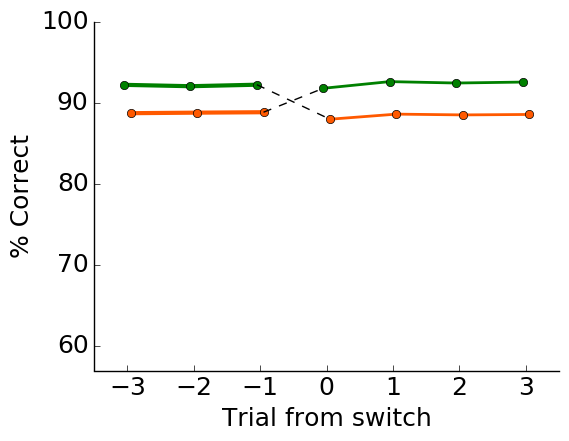

43


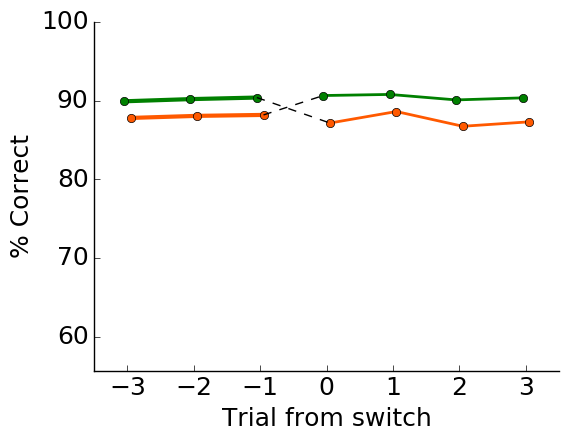

44


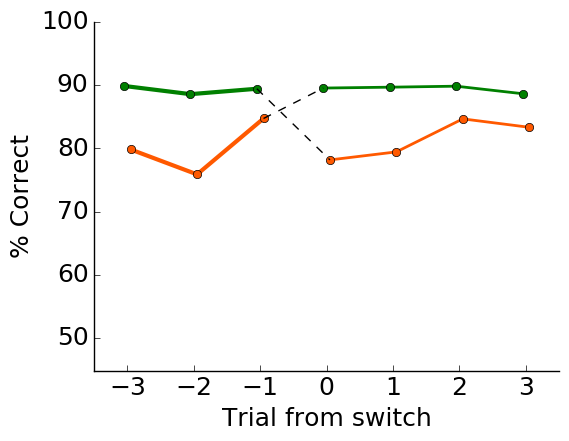

45


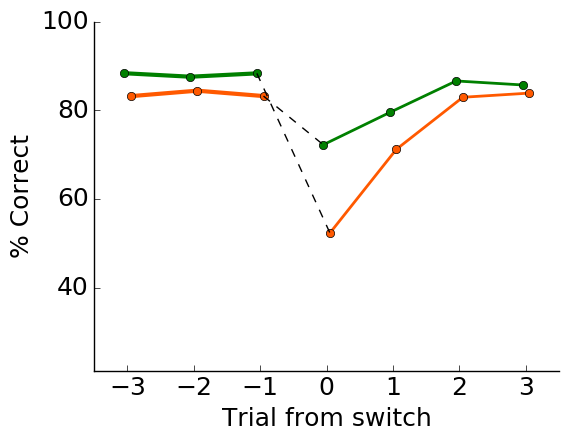

46


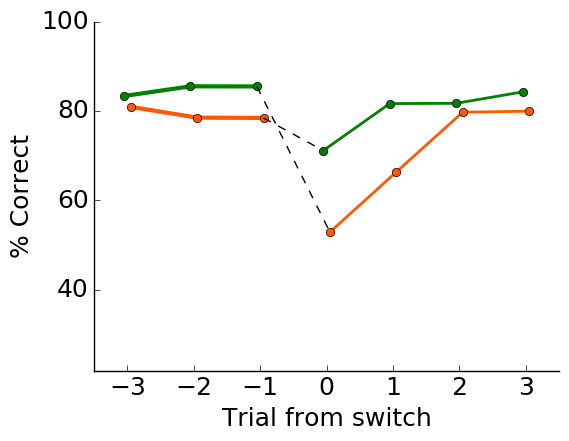

47


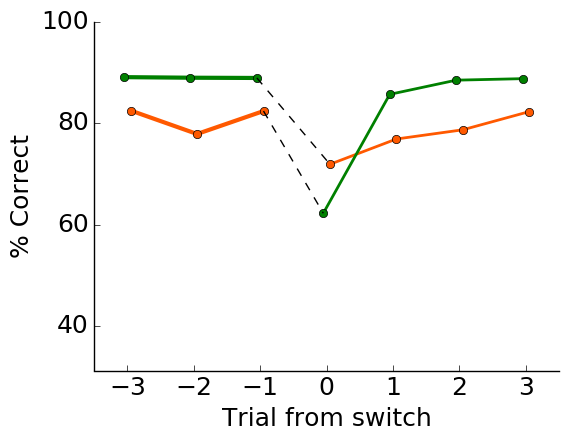

48


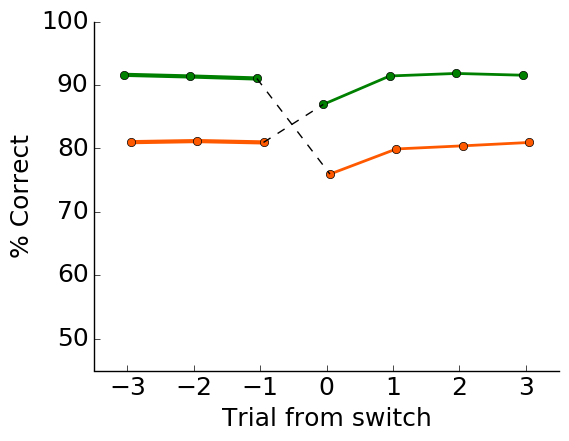

50


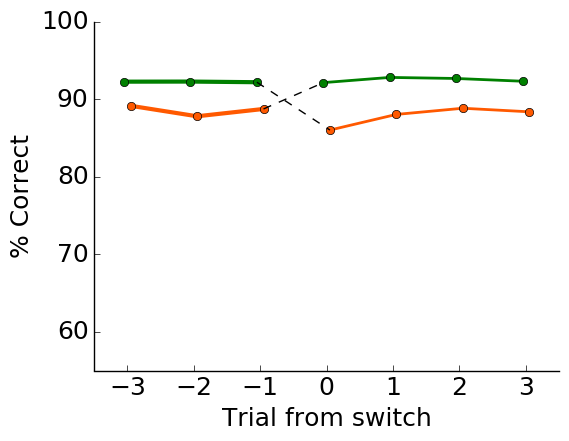

51


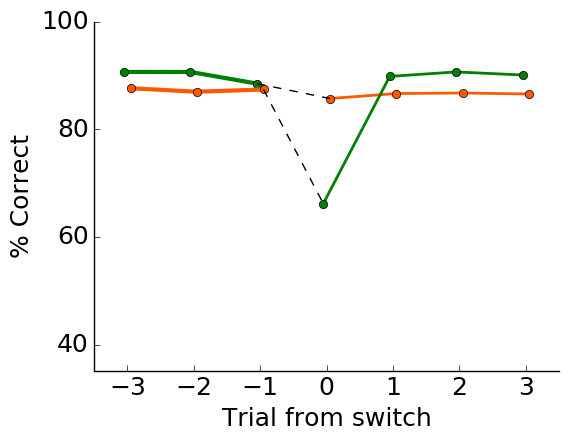

52


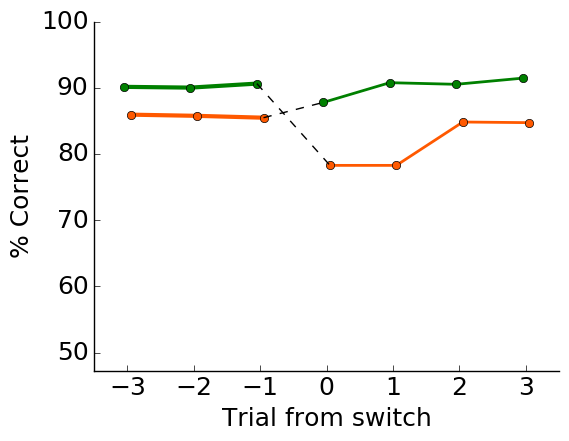

53


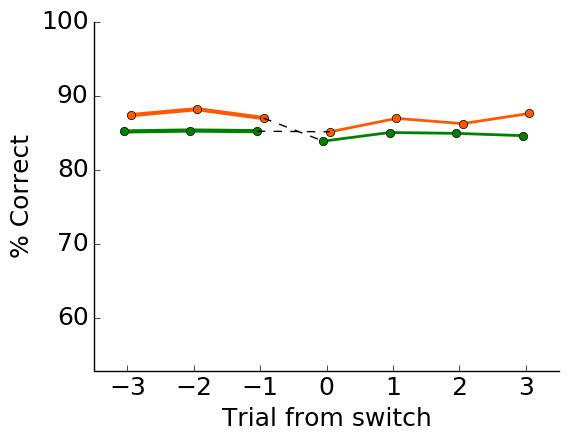

54


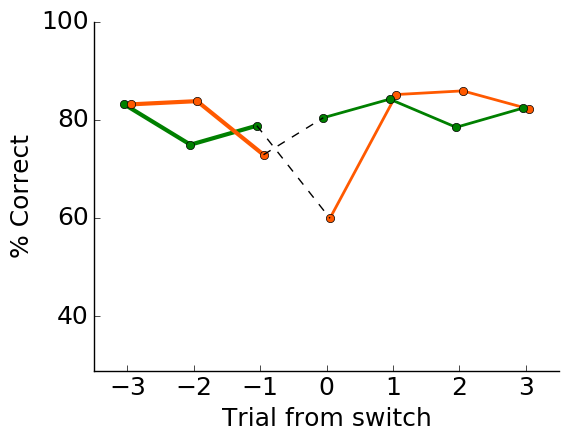

55


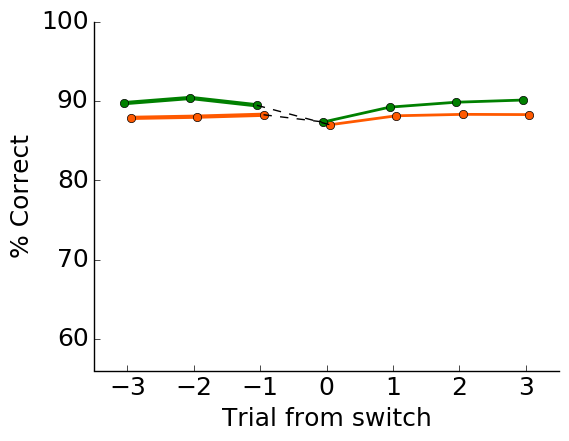

57


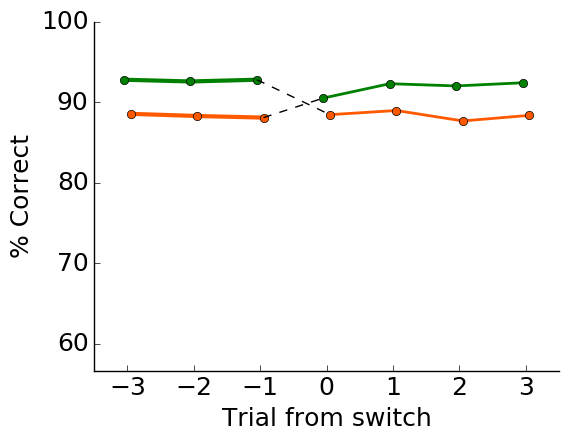

58


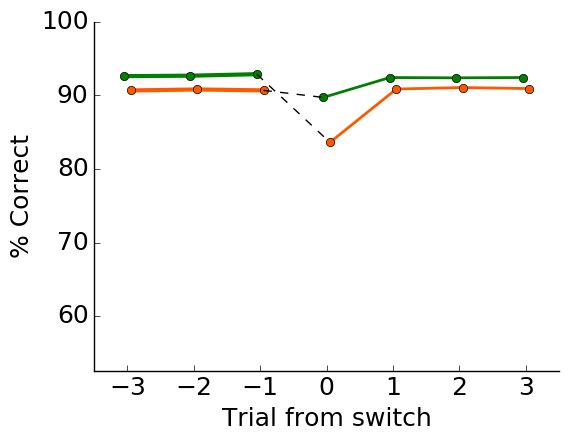

59


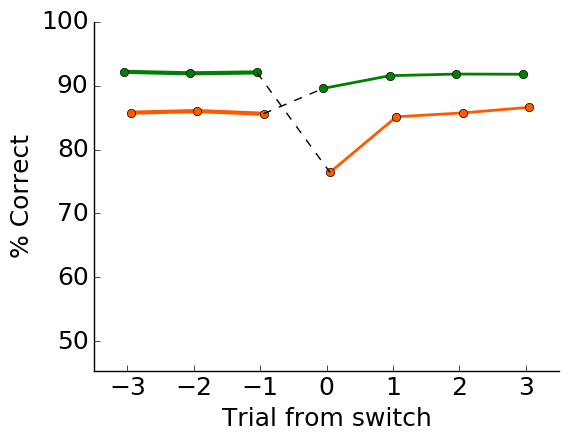

61


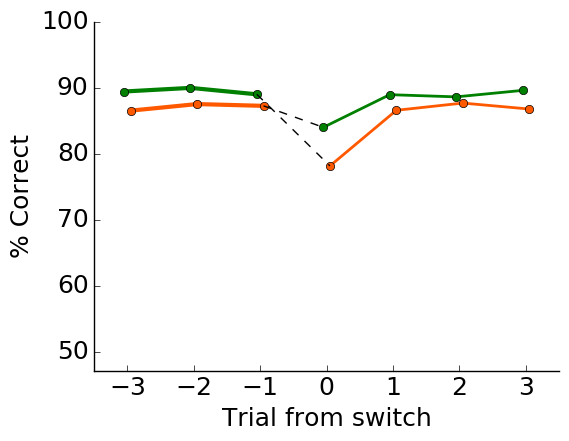

62


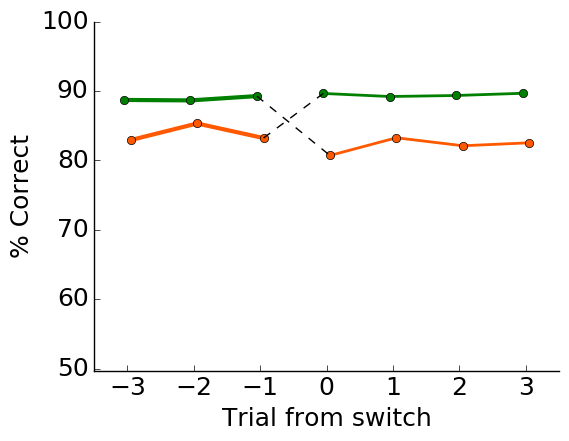

63


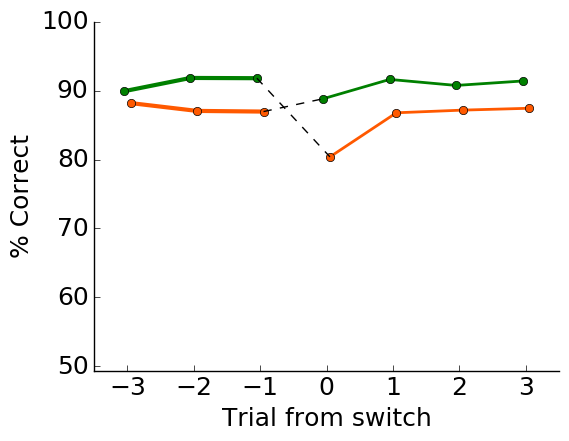

64


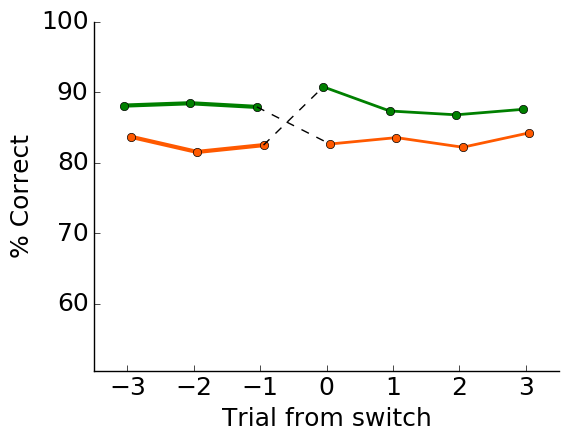

65


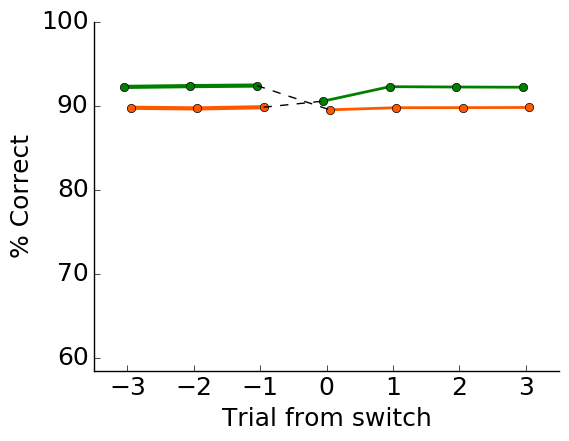

66


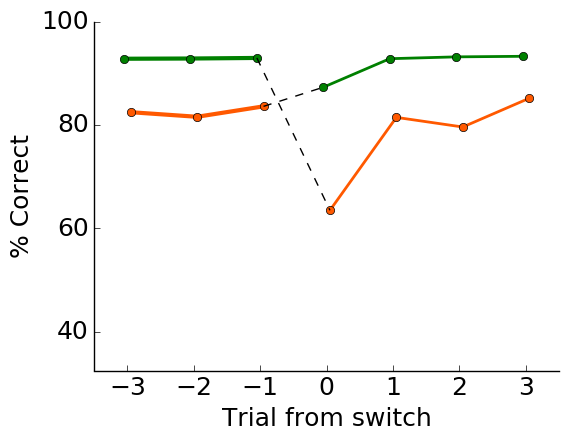

67


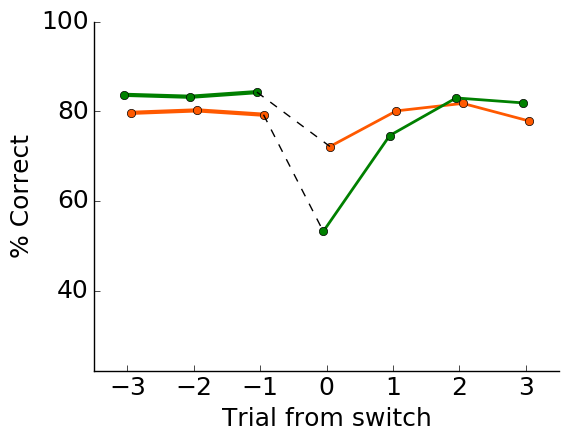

68


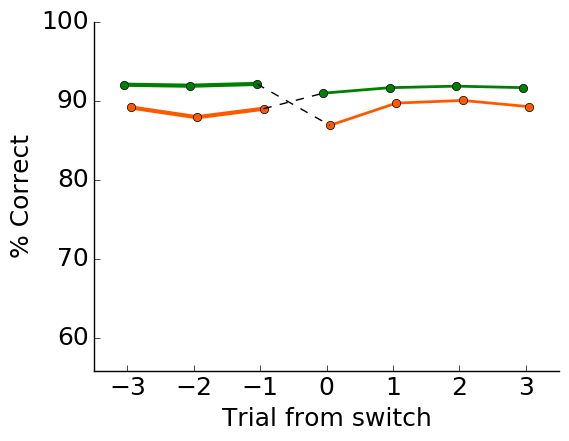

69


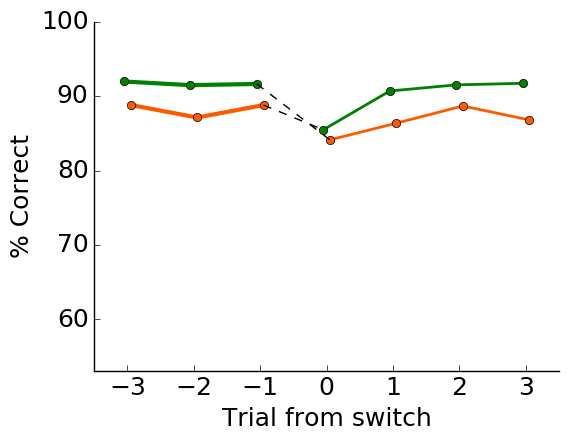

70


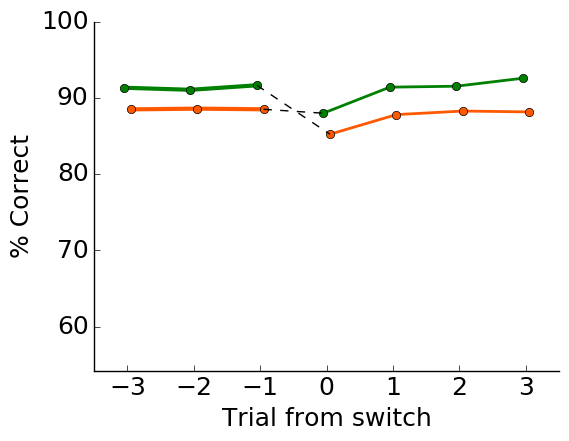

71


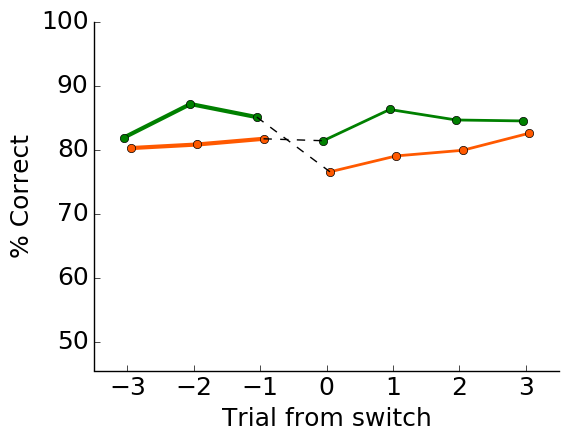

72


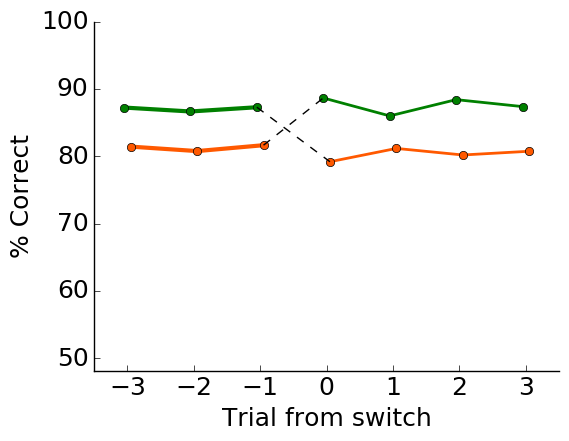

73


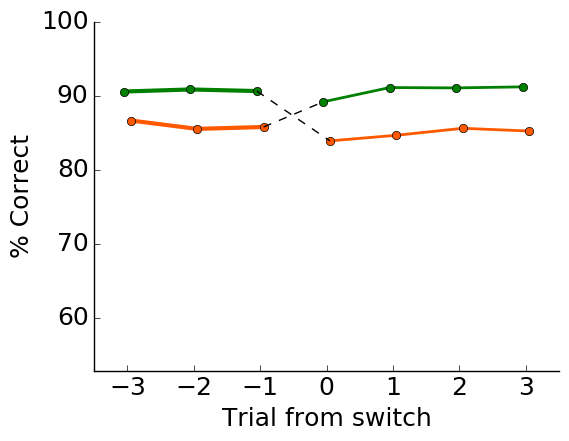

74


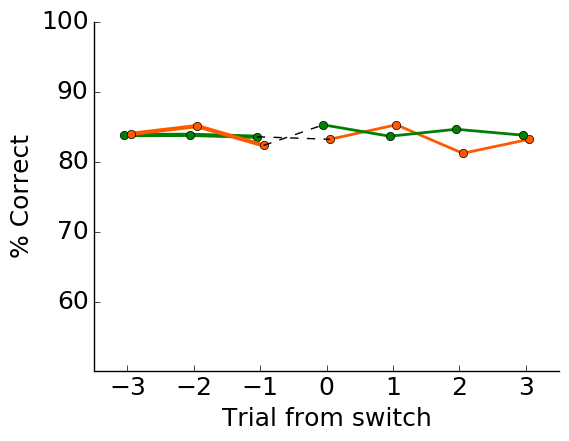

75


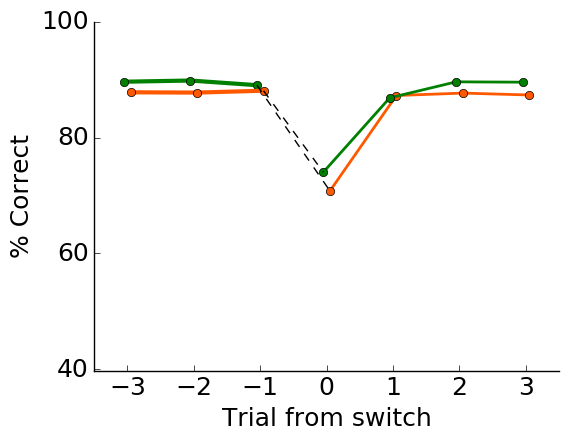

76


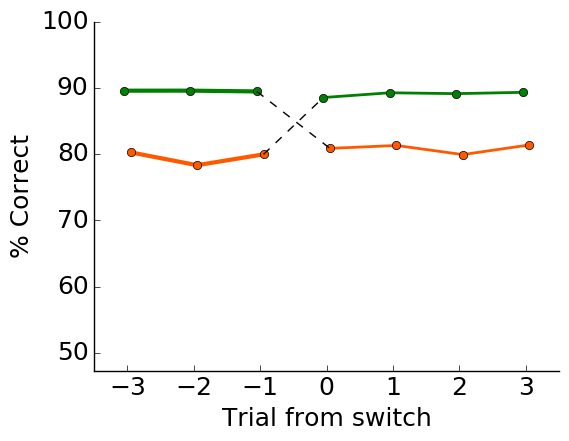

77


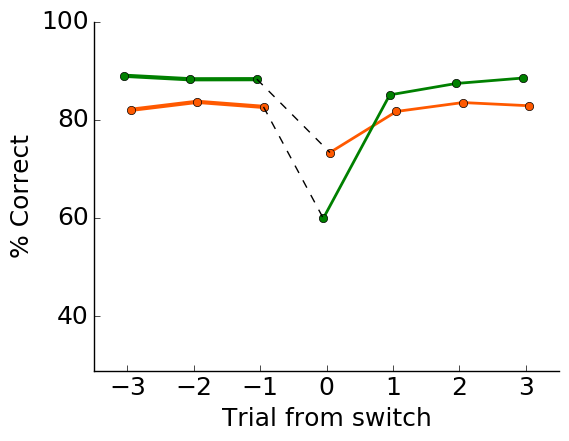

78


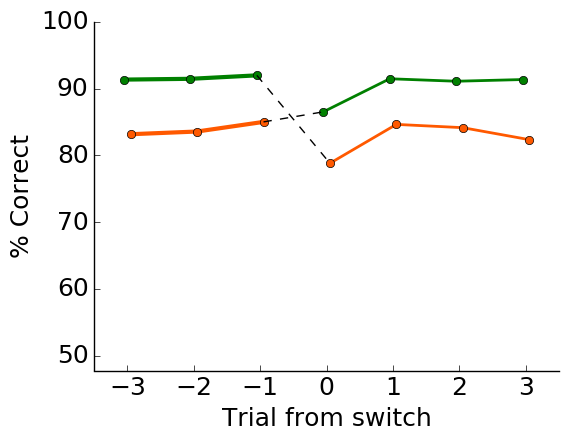

79


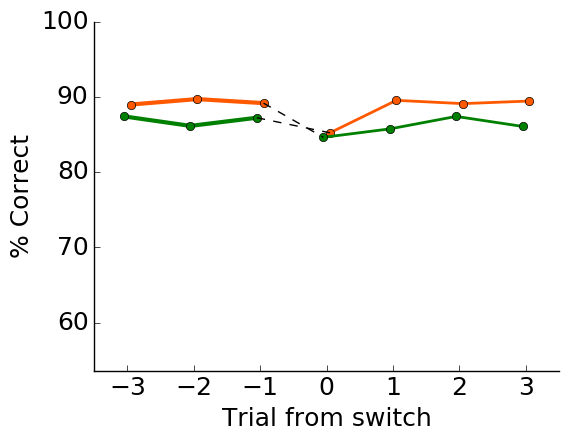

80


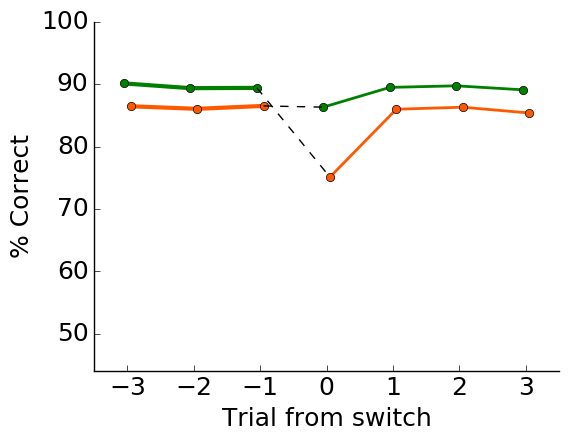

81


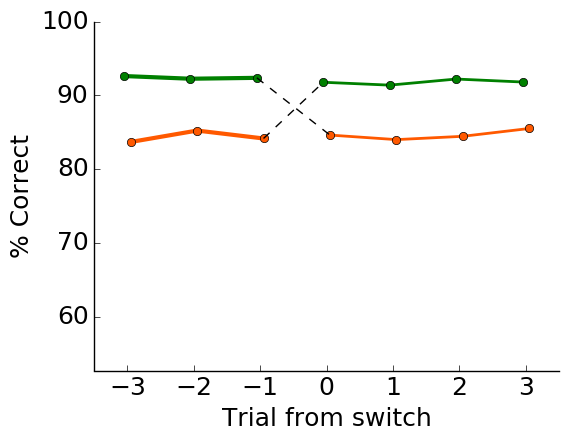

83


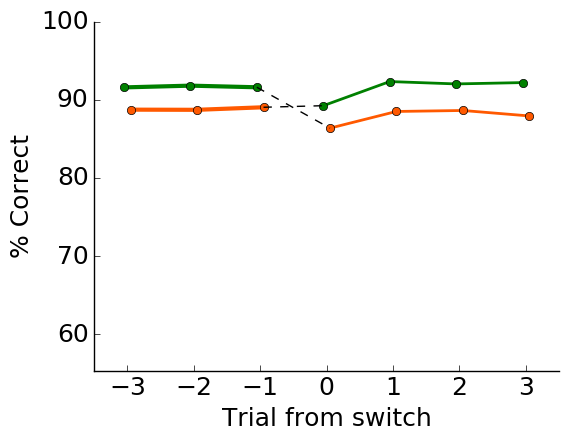

84


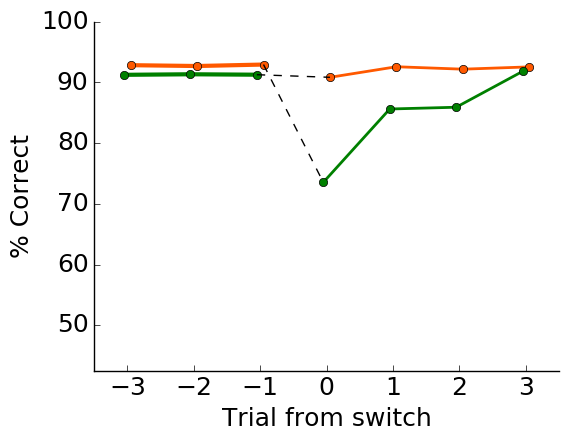

85


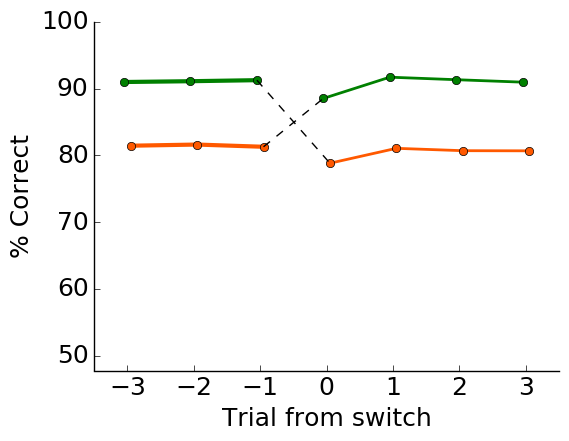

86


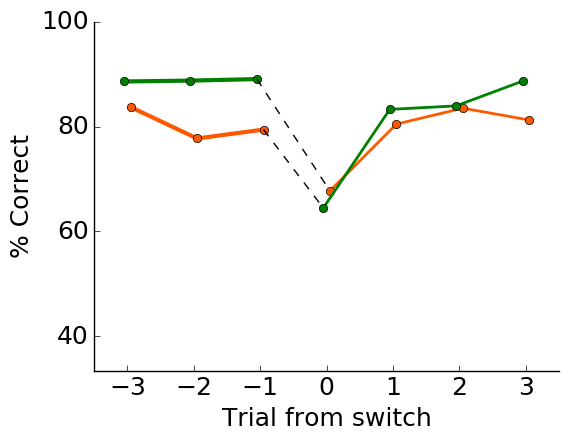

87


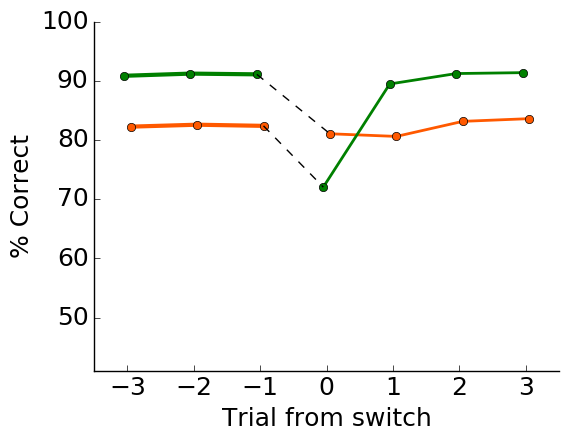

88


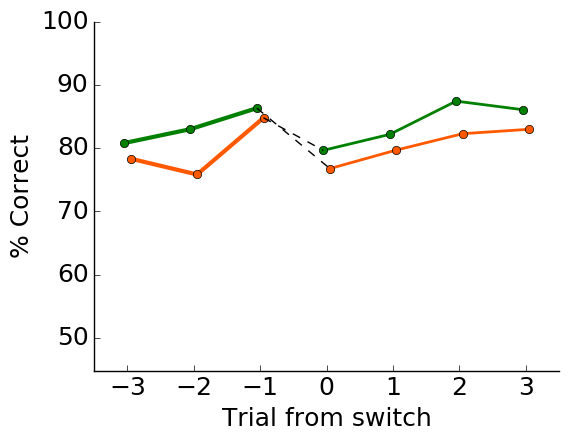

89


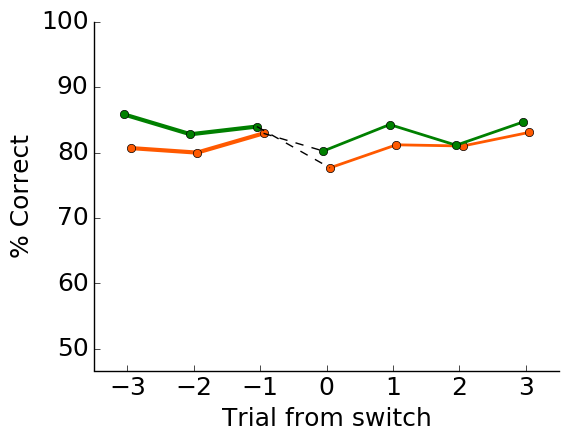

90


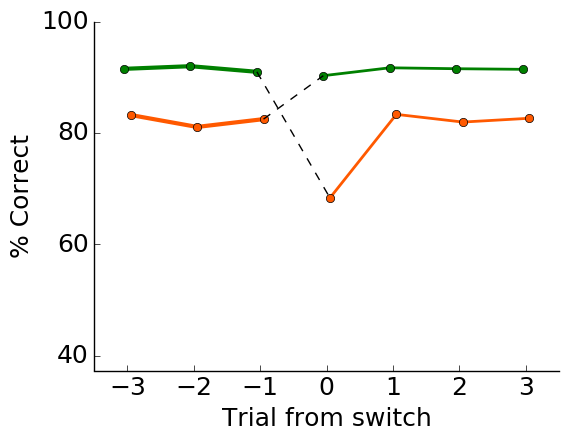

91


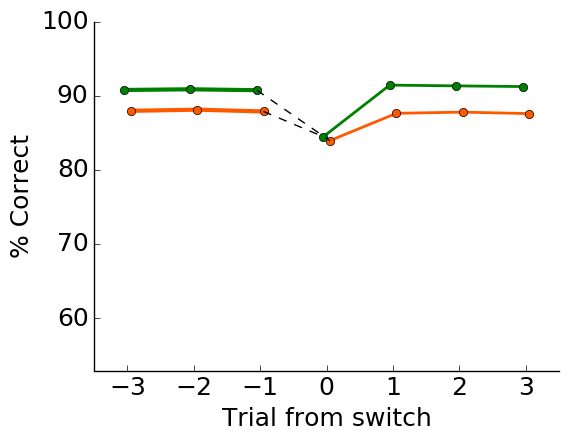

92


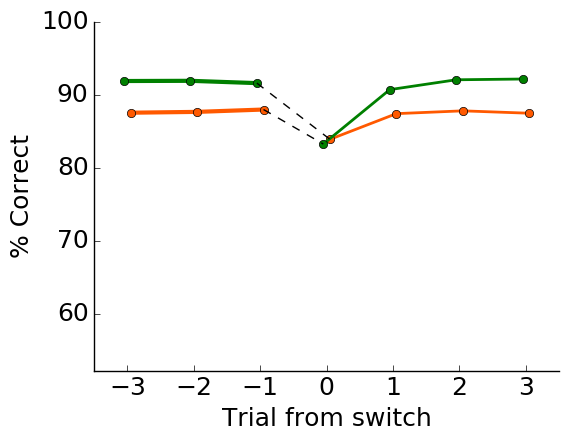

93


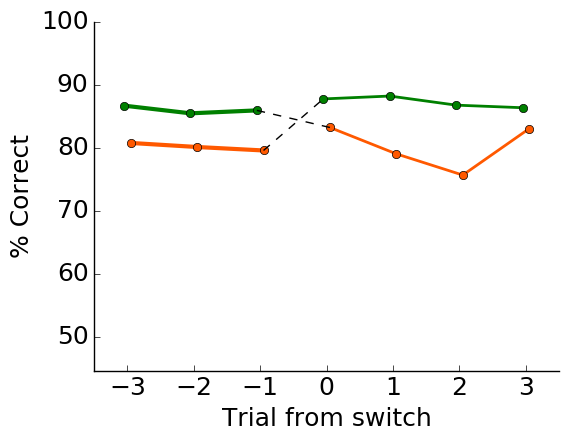

94


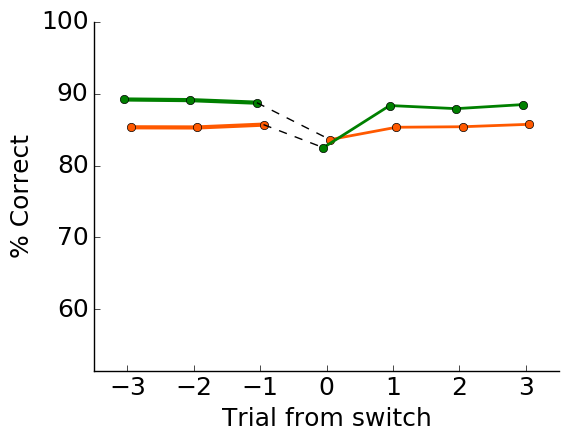

95


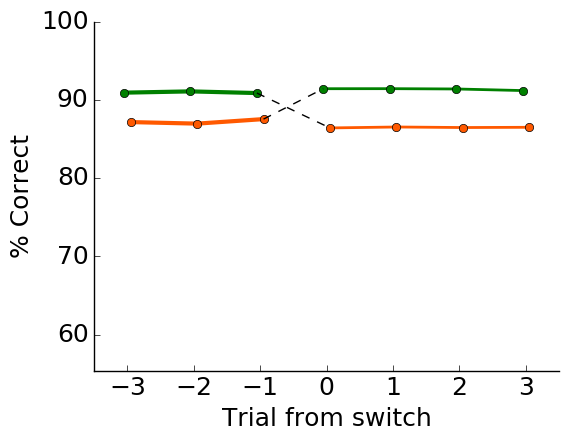

96


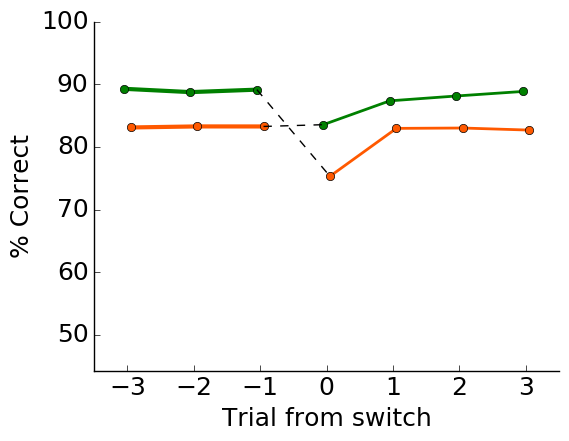

98


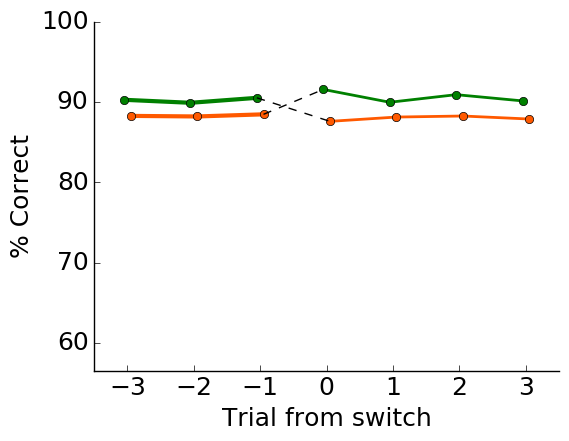

99


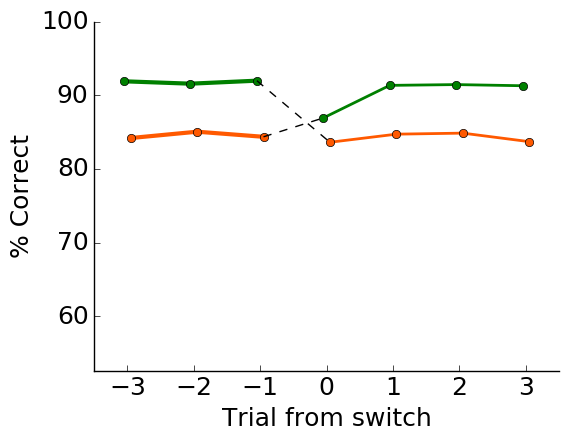

In [2]:
which_to_choose = load_weights("pkls/time_steps_for_3d-0.85.pkl")
rats = []
trial_window = 3
# Initialize mix experiment
pro_matrices = []
anti_matrices = []
normalized_pro_matrices = []
normalized_anti_matrices = []

for i in range(len(which_to_choose)):
    ratname = which_to_choose[i][0]
    try:
        loaded_params = load_weights("/scratch/xl1066/VirtualRat/publication/TrainingTime/trainedTrainingTime-"+\
                                     str(which_to_choose[i][0])+"-"+str(which_to_choose[i][1]*100)+".pkl")
        print ratname
    except IOError:
        continue
    np.random.seed(which_to_choose[i][0])
    npp.random.seed(which_to_choose[i][0])
    box = VirtualRatBox(mode="alternative",length=1000,block_size=30)
    test_X, test_y = box.X, box.y
    model = VirtualRatModel()
    rat = VirtualRat(model,ratname = ratname, trial_window = trial_window)
    rats.append(rat)
    solver = VirtualRatSolver(model, box) # Dummmy solver in order to load weights.
    np.random.seed(which_to_choose[i][0])
    npp.random.seed(which_to_choose[i][0])
    solver.init()
    solver.load_params(loaded_params)
    probs = rat.predict(test_X, test_y)
    draw_3d(rat.p2a_prob*100, rat.a2p_prob*100, trial_window = trial_window, fixed_size= False)
    rat.compute_PETH_ROC()
    rat.add_prediction_history()
    if not rat.exclude:
        # Perform mixing activation experiment
        pro_matrix = rat.mixActivation(original_config_name = "pro block", opposite_config_name = "anti block")
        anti_matrix = rat.mixActivation(original_config_name = "anti block", opposite_config_name = "pro block")
        pro_matrices.append(pro_matrix)
        anti_matrices.append(anti_matrix)
        normalized_pro_matrices.append((pro_matrix-rat.pro_block_accuracy)/rat.pro_switch_cost)
        normalized_anti_matrices.append((anti_matrix - rat.anti_block_accuracy)/rat.anti_switch_cost)

In [3]:
# Compute and save pkls for switch cost figure
p2a_matrix, a2p_matrix = figure_3d_matrix(rats,trial_window = trial_window)
save_weights("pkls/figure3d_p2a_matrix-0.85.pkl",p2a_matrix)
save_weights("pkls/figure3d_a2p_matrix-0.85.pkl",a2p_matrix)

# Compute and save pkls for switch cost histogram
pro_switch_cost, anti_switch_cost = rat2matrix([rats], exclude = True)
switch_cost_difference = pro_switch_cost[0,:] - anti_switch_cost[0,:]
save_weights("pkls/switch_cost_difference-0.85.pkl",switch_cost_difference)

# Compute and save pkls for rule selective cells
pro_selective, anti_selective = ROC_matrix(rats)
save_weights("pkls/pro_selective-0.85.pkl",pro_selective)
save_weights("pkls/anti_selective-0.85.pkl",anti_selective)

# Compute and save pkls for target selective cells
left_selective, right_selective = ROC_target_matrix(rats)
save_weights("pkls/left_selective-0.85.pkl",left_selective)
save_weights("pkls/right_selective-0.85.pkl",right_selective)

# Compute and save pkls for rule flipping neurons
auc, significant = AUC_matrix(rats,AUC_name = "AUC", significant_name = "AUC_significant")
save_weights("pkls/auc-0.85.pkl",auc)
save_weights("pkls/auc_significant-0.85.pkl",significant)

# Compute and save pkls for target flipping neurons
auc_target, significant_target = AUC_matrix(rats,AUC_name = "AUC_target", significant_name = "AUC_target_significant")
save_weights("pkls/auc_target-0.85.pkl",auc_target)
save_weights("pkls/auc_significant_target-0.85.pkl",significant_target)

# Compute and save pkls for mixing activation experiment
normalized_pro = np.array(normalized_pro_matrices)
normalized_anti = np.array(normalized_anti_matrices)
save_weights("pkls/mix_pro-0.85.pkl",normalized_pro)
save_weights("pkls/mix_anti-0.85.pkl",normalized_anti)

In [5]:
# Make table for running LME in MATLAB
categories = 15 # RNN_index, pro, right, switch, hit_rate, (index 0~4)
                # score0, score1, score2, score3, score4, (index 5~9)
                # encoding0, encoding1, encoding2, encoding3, encoding4 (index 10~14)
SGD_table = np.zeros((0,categories))
SGD_table_target = np.zeros((0,categories))
for rat in rats:
    print "Computing VirtualRat #%d" % (rat.name,)
    rat.run_SGD()
    rat.get_SGD_score(rat.config_names)
    rule_table = rat.make_SGD_table(normalize=True)
    target_table = rat.make_SGD_table(target=True,normalize=True)
    SGD_table = np.append(SGD_table,rule_table,axis=0)
    SGD_table_target = np.append(SGD_table_target,target_table,axis=0)
sio.savemat('mats/SGD_table_RNN.mat',{'SGD_table':SGD_table})
sio.savemat('mats/SGD_table_target_RNN.mat',{'SGD_table':SGD_table_target})

Computing VirtualRat #1
Computing VirtualRat #2
Computing VirtualRat #3
Computing VirtualRat #4
Computing VirtualRat #5
Computing VirtualRat #6
Computing VirtualRat #8
Computing VirtualRat #9
Computing VirtualRat #10
Computing VirtualRat #11
Computing VirtualRat #13
Computing VirtualRat #14
Computing VirtualRat #15
Computing VirtualRat #16
Computing VirtualRat #17
Computing VirtualRat #18
Computing VirtualRat #19
Computing VirtualRat #20
Computing VirtualRat #21
Computing VirtualRat #22
Computing VirtualRat #23
Computing VirtualRat #24
Computing VirtualRat #25
Computing VirtualRat #26
Computing VirtualRat #27
Computing VirtualRat #28
Computing VirtualRat #29
Computing VirtualRat #30
Computing VirtualRat #31
Computing VirtualRat #32
Computing VirtualRat #33
Computing VirtualRat #34
Computing VirtualRat #35
Computing VirtualRat #36
Computing VirtualRat #37
Computing VirtualRat #38
Computing VirtualRat #39
Computing VirtualRat #40
Computing VirtualRat #41
Computing VirtualRat #42
Computin

# Run codes from here to regenerate figures from pkl files.

In [6]:
p2a_matrix = load_weights("pkls/figure3d_p2a_matrix-0.85.pkl")
a2p_matrix = load_weights("pkls/figure3d_a2p_matrix-0.85.pkl")

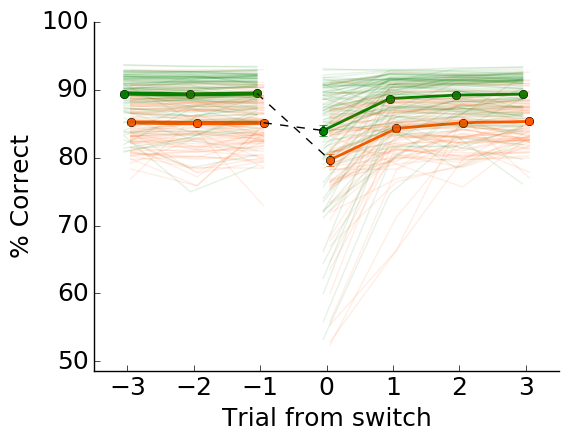

In [7]:
trial_window = 3
#draw_3d(p2a_matrix = p2a_matrix, a2p_matrix = a2p_matrix, trial_window = trial_window, fixed_size = False, 
#    shift=0.05, filename = "figures/figure3d.pdf")
draw_3d(p2a_matrix = p2a_matrix, a2p_matrix = a2p_matrix, trial_window = trial_window, fixed_size = False, shift=0.05)

In [8]:
switch_cost_difference = load_weights("pkls/switch_cost_difference-0.85.pkl")

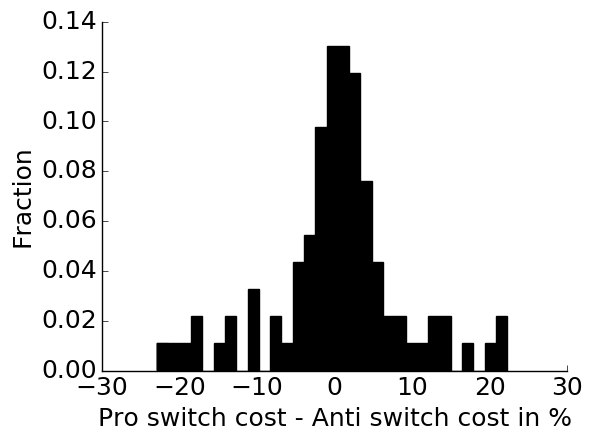

In [9]:
switch_cost_difference_to_plot = switch_cost_difference[np.logical_not(np.isnan(switch_cost_difference))]
#switch_cost_difference_histogram(switch_cost_difference_to_plot, bins = 31, filename = "figures/SC_histogram.pdf")
switch_cost_difference_histogram(switch_cost_difference_to_plot, bins = 31)

In [10]:
pro_selective = load_weights("pkls/pro_selective-0.85.pkl")
anti_selective = load_weights("pkls/anti_selective-0.85.pkl")
left_selective = load_weights("pkls/left_selective-0.85.pkl")
right_selective = load_weights("pkls/right_selective-0.85.pkl")

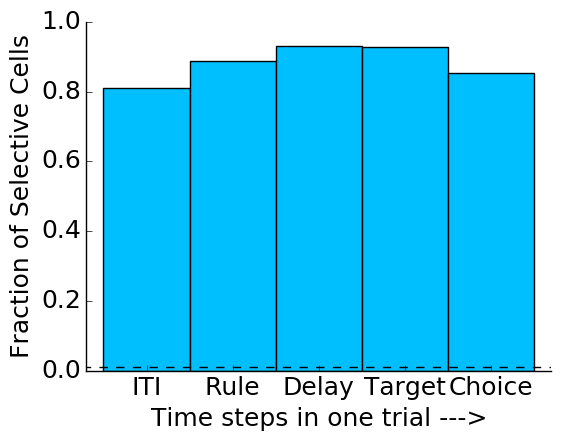

In [11]:
#ROC(pro_selective, anti_selective, filename="figures/ROC_rule_encoding.pdf")
ROC(pro_selective, anti_selective)

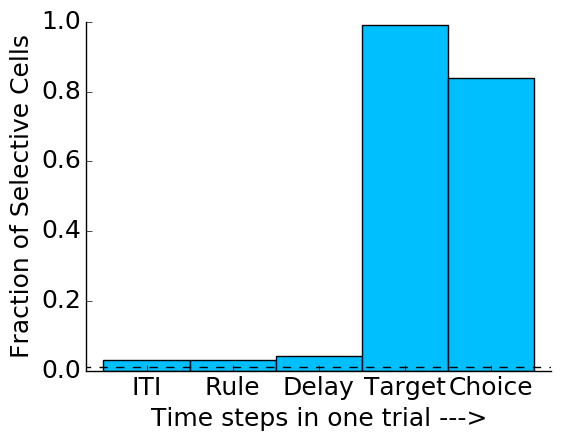

In [12]:
#ROC_target(left_selective, right_selective, filename="figures/ROC_target_encoding.pdf")
ROC_target(left_selective, right_selective)

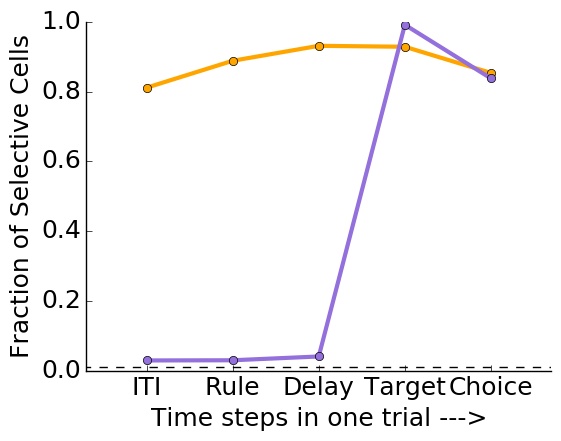

In [13]:
#ROC_combine(pro_selective, anti_selective, left_selective, right_selective, filename="figures/ROC_combine.pdf")
ROC_combine(pro_selective, anti_selective, left_selective, right_selective)

In [14]:
auc = load_weights("pkls/auc-0.85.pkl")
significant = load_weights("pkls/auc_significant-0.85.pkl")

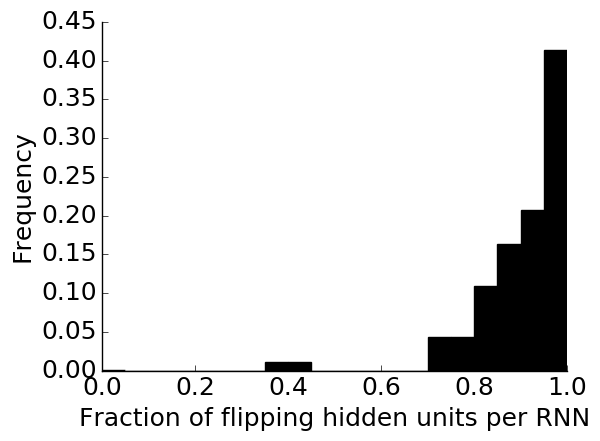

In [15]:
#AUC_flip_histogram(rats = None, AUC = auc, significant = significant, filename = "figures/Rule_flip.pdf")
AUC_flip_histogram(rats = None, AUC = auc, significant = significant)

In [ ]:
auc_target = load_weights("pkls/auc_target-0.85.pkl")
significant_target = load_weights("pkls/auc_significant_target-0.85.pkl")

In [ ]:
#AUC_flip_histogram(rats = None, AUC = auc_target, significant = significant_target, filename = "figures/target_flip.pdf")
AUC_flip_histogram(rats = None, AUC = auc_target, significant = significant_target)

In [ ]:
normalized_pro = load_weights("pkls/mix_pro-0.85.pkl")
normalized_anti = load_weights("pkls/mix_anti-0.85.pkl")
normalized = np.append(normalized_pro,normalized_anti,axis=0)

In [ ]:
#mixActivationMedian(normalized, filename = "figures/mix.pdf")
mixActivationMedian(normalized)